In [ ]:
!pip install -U --pre tensorflow=="2.*"

In [ ]:
!pip install pycocotools

In [ ]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
cd models/research

/content/models/research


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!pip install object_detection

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
!pip install tf_slim

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)
  print(base_url + model_file)
  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [ ]:
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
PATH_TO_TEST_VIDEO_DIR=pathlib.Path('object_detection/test_video')
TEST_VIDEO_PATHS = sorted(list(PATH_TO_TEST_VIDEO_DIR.glob("*.mp4")))
# TEST_VIDEO_PATHS
TEST_IMAGE_PATHS

[PosixPath('object_detection/test_images/banana4.jpg'),
 PosixPath('object_detection/test_images/broccoli2.jpg'),
 PosixPath('object_detection/test_images/cake1.jpg'),
 PosixPath('object_detection/test_images/carrot_hd_picture_1_167249.jpg'),
 PosixPath('object_detection/test_images/image2.jpg'),
 PosixPath('object_detection/test_images/istockphoto-184927564-170667a.jpg')]

In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76534733/76534733 [==============================] - 1s 0us/step
http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz


In [ ]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32}

In [ ]:
c=TEST_VIDEO_PATHS[0]
str(c)
print(c)

object_detection/test_video/testVideoArun.mp4


In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  output_dict = model(input_tensor)
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
import xml.etree.ElementTree as xml

In [ ]:
xml.Element("Frame")

<Element 'Frame' at 0x7f279dc5d630>

In [ ]:
def GenerateXML(fileName,res_names,res_area):
    root = xml.Element("Frame")

    for i in range(len(res_area)):
        c1 = xml.Element("Object")
        root.append(c1)

        type1 = xml.SubElement(c1,"Name")
        type1.text = res_names[i]

        type2 = xml.SubElement(c1,"Area")
        type2.text = str(res_area[i])

    tree = xml.ElementTree(root)
    filename = os.path.join("/content/models/research/object_detection/Framesxml", fileName) 
    with open(filename,"wb") as files:
        tree.write(files)

In [ ]:
def show_inference(model, image_path,class_id,j):

  image_np = np.array(Image.open(image_path))
  # print(image_np)
  output_dict = run_inference_for_single_image(model, image_np)
  boxes = []
  classes = []
  scores = []
  res_names = []
  res_area = []
  for i,x in enumerate(output_dict['detection_classes']):
    if output_dict['detection_scores'][i] > 0.5:
      classes.append(x)
      boxes.append(output_dict['detection_boxes'][i])
      scores.append(output_dict['detection_scores'][i])
  boxes = np.array(boxes)
  classes = np.array(classes)
  scores = np.array(scores)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      boxes,
      classes,
      scores,
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)
  for k,x in enumerate(output_dict['detection_classes']):
    if output_dict['detection_scores'][k] > 0.5:
      if(classes.size>0):
        res_names.append(category_index[classes[0]]["name"])
        aaa = (output_dict['detection_boxes'][k][3]-output_dict['detection_boxes'][k][1])
        bbb = (output_dict['detection_boxes'][k][2]-output_dict['detection_boxes'][k][0])
        area = bbb*aaa
        res_area.append(area)
  root = xml.Element("Frame")

  for i in range(len(res_area)):
      c1 = xml.Element("Object")
      root.append(c1)

      type1 = xml.SubElement(c1,"Name")
      type1.text = res_names[i]

      type2 = xml.SubElement(c1,"Area")
      type2.text = str(res_area[i])

  tree = xml.ElementTree(root)
  filename = os.path.join("/content/models/research/object_detection/Framesxml", "Image"+str(j)) 
  with open(filename,"wb") as files:
      tree.write(files)



  # print(res_area)
        # print(category_index[classes[0]]["name"])
  display(Image.fromarray(image_np))

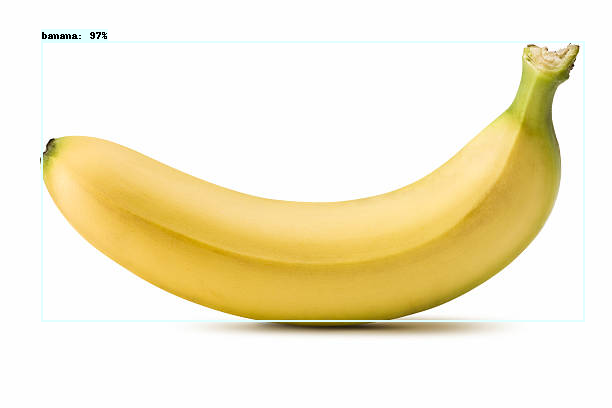

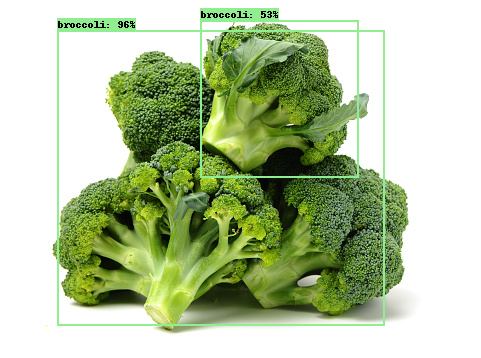

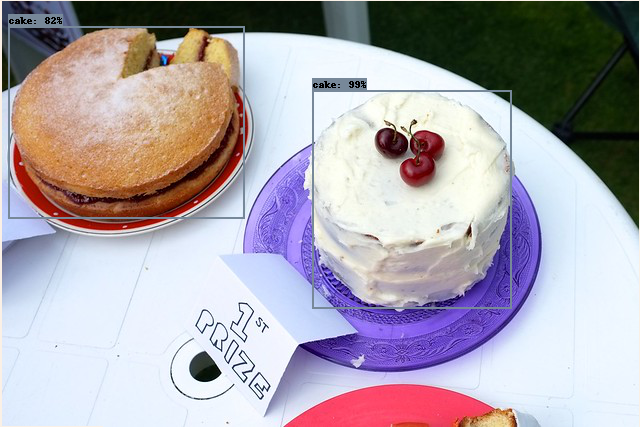

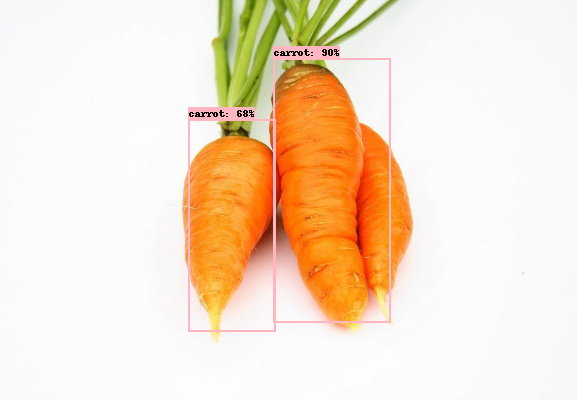

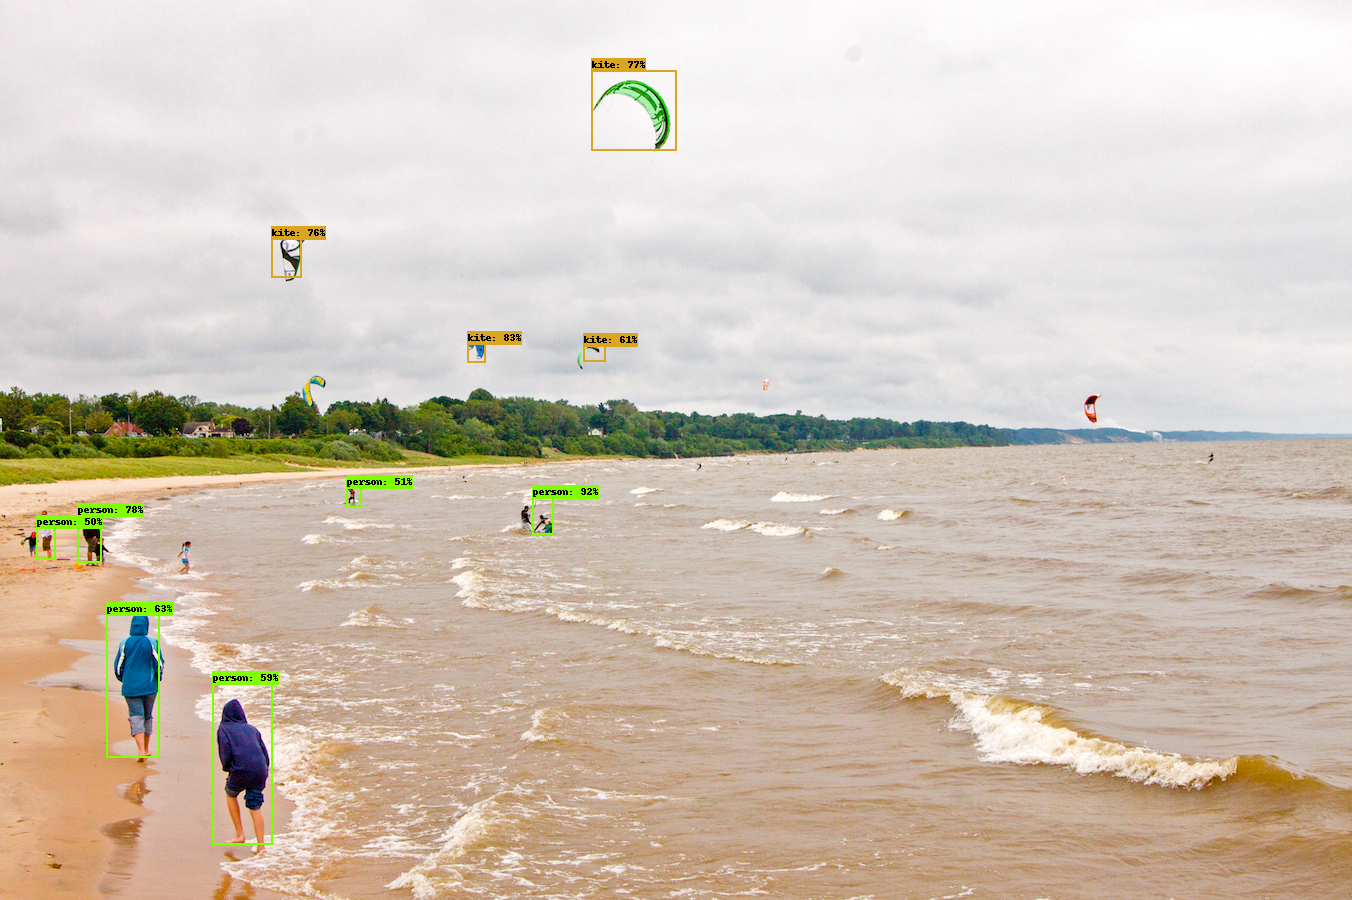

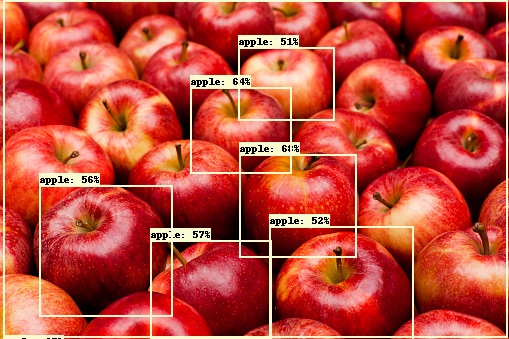

In [ ]:
j=0
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path,1,j)
  j+=1

In [ ]:
import cv2
vidcap = cv2.VideoCapture(str(c))
success,image = vidcap.read()
print(image)
count = 0
path = '/content/models/research/object_detection/VidFrames'

while success:
    
  cv2.imwrite(os.path.join(path , "frame%d.jpg" % count), image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new

In [ ]:
cap=vidcap
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap=cv2.VideoCapture(str(c))
# ret,frame = cap.read()
id=0
while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)
    print(frame)
    # output_dict = run_inference_for_single_image(detection_model, image_np)
    # boxes = []
    # classes = []
    # scores = []
    # res_names = []
    # res_area = []
    # for i,x in enumerate(output_dict['detection_classes']):
    #   if output_dict['detection_scores'][i] > 0.5:
    #     classes.append(x)
    #     boxes.append(output_dict['detection_boxes'][i])
    #     scores.append(output_dict['detection_scores'][i])
    # boxes = np.array(boxes)
    # classes = np.array(classes)
    # scores = np.array(scores)
    # vis_util.visualize_boxes_and_labels_on_image_array(
    #     image_np,
    #     boxes,
    #     classes,
    #     scores,
    #     category_index,
    #     instance_masks=output_dict.get('detection_masks_reframed', None),
    #     use_normalized_coordinates=True,
    #     line_thickness=2)
    # for k,x in enumerate(output_dict['detection_classes']):
    #   if output_dict['detection_scores'][k] > 0.5:
    #     if(classes.size>0):
    #       res_names.append(category_index[classes[0]]["name"])
    #       aaa = (output_dict['detection_boxes'][k][3]-output_dict['detection_boxes'][k][1])
    #       bbb = (output_dict['detection_boxes'][k][2]-output_dict['detection_boxes'][k][0])
    #       area = bbb*aaa
    #       res_area.append(area)
    # root = xml.Element("Frame")

    # for i in range(len(res_area)):
    #     c1 = xml.Element("Object")
    #     root.append(c1)

    #     type1 = xml.SubElement(c1,"Name")
    #     type1.text = res_names[i]

    #     type2 = xml.SubElement(c1,"Area")
    #     type2.text = str(res_area[i])

    # tree = xml.ElementTree(root)
    # filename = os.path.join("/content/models/research/object_detection/VidFramesxml", "Image"+str(j)) 
    # with open(filename,"wb") as files:
    #     tree.write(files)



    # # print(res_area)
    #       # print(category_index[classes[0]]["name"])
    # display(Image.fromarray(image_np))

Streaming output truncated to the last 5000 lines.
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None

KeyboardInterrupt: ignored